In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

data_dir = '/content/drive/MyDrive/lung_dataset'  # update path if needed

print("Folders in your dataset:")
print(os.listdir(data_dir))


Folders in your dataset:
['Malignant cases', 'Normal cases', 'Benign cases']


In [ ]:
import cv2
import numpy as np

IMG_SIZE = 224

# Map folder names to integer labels
label_map = {
    'Benign cases': 0,
    'Malignant cases': 1,
    'Normal cases': 2
}

data = []
labels = []

print("Loading and preprocessing images...")

for folder in label_map:
    folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(folder_path):
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                img = img / 255.0
                data.append(img)
                labels.append(label_map[folder])

X = np.array(data)
y = np.array(labels)

print("✅ Images loaded. Shape:", X.shape)
print("✅ Labels loaded. Shape:", y.shape)
print("Class distribution:", np.unique(y, return_counts=True))


Loading and preprocessing images...
✅ Images loaded. Shape: (1097, 224, 224, 3)
✅ Labels loaded. Shape: (1097,)
Class distribution: (array([0, 1, 2]), array([120, 561, 416]))


In [ ]:
from sklearn.model_selection import train_test_split

# Split data: 20% test, stratified by class
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))


Train shape: (877, 224, 224, 3) (877,)
Test shape: (220, 224, 224, 3) (220,)
Train class counts: [ 96 448 333]
Test class counts: [ 24 113  83]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 model (no top classifier, use global average pooling)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')
base_model.trainable = False  # We won't fine-tune (for now)

# Preprocess for EfficientNetB0
X_train_pp = preprocess_input(X_train.copy())
X_test_pp = preprocess_input(X_test.copy())

# Extract features
print("Extracting features from EfficientNetB0...")
X_train_feat = base_model.predict(X_train_pp, verbose=1)
X_test_feat = base_model.predict(X_test_pp, verbose=1)

print("Train features shape:", X_train_feat.shape)
print("Test features shape:", X_test_feat.shape)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Extracting features from EfficientNetB0...
28/28 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Train features shape: (877, 1280)
Test features shape: (220, 1280)



📋 Classification Report:
              precision    recall  f1-score   support

      Benign       0.00      0.00      0.00        24
   Malignant       0.00      0.00      0.00       113
      Normal       0.38      1.00      0.55        83

    accuracy                           0.38       220
   macro avg       0.13      0.33      0.18       220
weighted avg       0.14      0.38      0.21       220



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


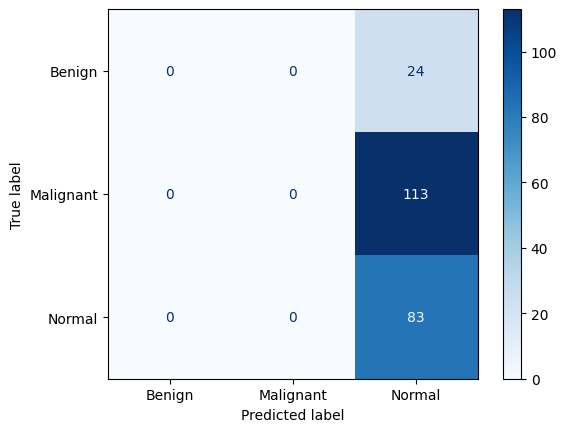

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Use class_weight='balanced' to help with class imbalance
svm = SVC(kernel='rbf', C=10, gamma='scale', class_weight='balanced', decision_function_shape='ovr')
svm.fit(X_train_feat, y_train)

y_pred = svm.predict(X_test_feat)

print("\n📋 Classification Report:")
target_names = ['Benign', 'Malignant', 'Normal']
print(classification_report(y_test, y_pred, target_names=target_names))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap='Blues')


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_feat_scaled = scaler.fit_transform(X_train_feat)
X_test_feat_scaled = scaler.transform(X_test_feat)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

grid = GridSearchCV(SVC(decision_function_shape='ovr'), param_grid, refit=True, cv=3, verbose=2)
grid.fit(X_train_feat_scaled, y_train)

print("Best params:", grid.best_params_)
y_pred = grid.predict(X_test_feat_scaled)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.5s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.7s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   0.8s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   2.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   1.6s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   1.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   0.3s
[CV] END C=0.1, class_weight=balanced, ga

              precision    recall  f1-score   support

      Benign       1.00      0.96      0.98        24
   Malignant       1.00      1.00      1.00       113
      Normal       0.99      1.00      0.99        83

    accuracy                           1.00       220
   macro avg       1.00      0.99      0.99       220
weighted avg       1.00      1.00      1.00       220



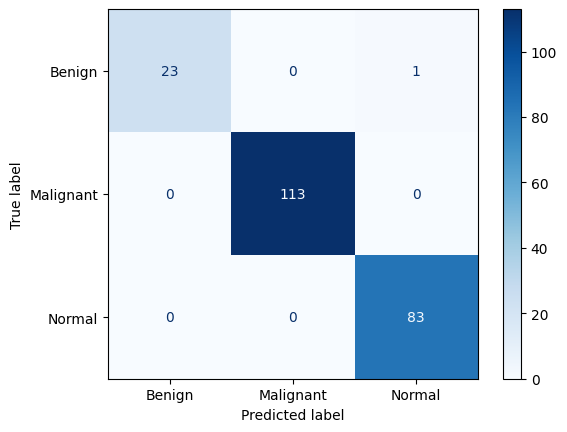

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

target_names = ['Benign', 'Malignant', 'Normal']
print(classification_report(y_test, y_pred, target_names=target_names))
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=target_names).plot(cmap='Blues')


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 with classifier for Grad-CAM
cnn_model = EfficientNetB0(weights="imagenet", include_top=True)


21834768/21834768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to generate Grad-CAM heatmap
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def display_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(cv2.cvtColor((img * 255).astype("uint8"), cv2.COLOR_RGB2BGR), 1-alpha, heatmap, alpha, 0)
    return overlayed


In [ ]:
# Find indices for each class in test set
idx_benign = next(i for i, label in enumerate(y_test) if label == 0)
idx_malignant = next(i for i, label in enumerate(y_test) if label == 1)
idx_normal = next(i for i, label in enumerate(y_test) if label == 2)

examples = {
    0: idx_benign,
    1: idx_malignant,
    2: idx_normal
}


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_239']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


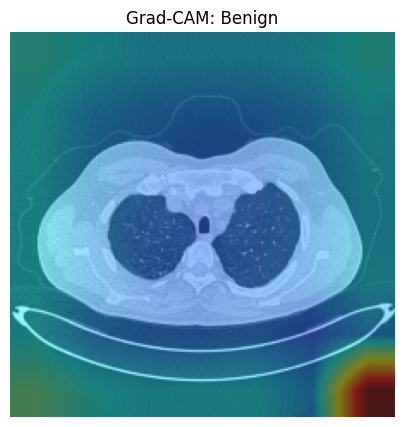

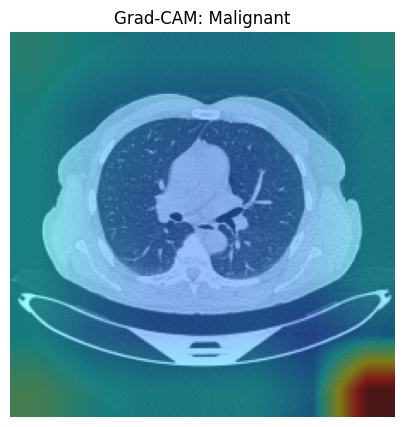

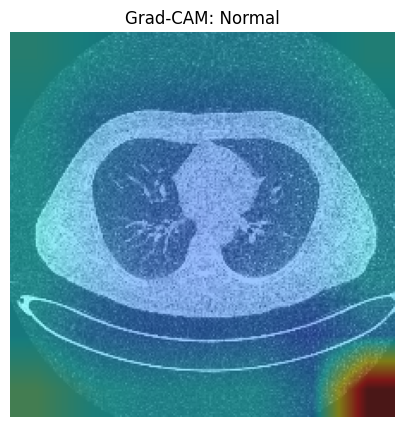

In [ ]:
class_names = ['Benign', 'Malignant', 'Normal']

for label, idx in examples.items():
    img = X_test[idx]
    img_input = np.expand_dims(preprocess_input(img.copy()), axis=0)

    heatmap = get_gradcam_heatmap(cnn_model, img_input, last_conv_layer_name="top_conv")
    overlay = display_gradcam(img, heatmap)

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM: {class_names[label]}")
    plt.axis('off')
    plt.show()
